### to Install

pip install tensorflow exifread

In [2]:
## Import necessary libraries

import jupyterlab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import exifread
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Deep Learning & TensorFlow
import tensorflow as tf
import tensorflow_hub as hub



# 01. DATA COLLECTION AND PROCESSING

#### 01.1 Convert GPS coordinates from EXIF format to decimal format.

In [3]:
def convert_gps_to_decimal(gps_data, ref):
    """Convert GPS coordinates from EXIF format to decimal format."""
    if gps_data:
        degrees = float(gps_data.values[0].num) / float(gps_data.values[0].den)
        minutes = float(gps_data.values[1].num) / float(gps_data.values[1].den)
        seconds = float(gps_data.values[2].num) / float(gps_data.values[2].den)

        decimal_coord = degrees + (minutes / 60) + (seconds / 3600)
        if ref in ['S', 'W']:
            decimal_coord = -decimal_coord  # Convert to negative for South and West
        return decimal_coord
    return None


#### 01.2 Define Dataset Paths

In [4]:
# Define dataset path (including subfolders)
dataset_path = r"E:\ML Train\00_Josef-Orlopp"

# Define base output path for CSV files
output_dir = r"C:\Users\Edu\Documents\GitHub\DeepPrune\data"
base_filename = "photogrammetry_dataset"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Find the next available filename with "_01", "_02" format
file_number = 1
while True:
    formatted_number = f"_{file_number:02d}"  # Format number as "_01", "_02", etc.
    output_csv_path = os.path.join(output_dir, f"{base_filename}{formatted_number}.csv")
    if not os.path.exists(output_csv_path):  # Check if filename is available
        break
    file_number += 1


### 01.3 Process images and extract metadata

In [5]:
# Initialize a list to store image metadata
image_data = []

# Loop through all files in the dataset folder and subfolders
for root, _, files in os.walk(dataset_path):  # Recursively explore subdirectories
    for img in files:
        if img.lower().endswith(('.jpg', '.jpeg', '.png')):  # Process only image files
            img_path = os.path.join(root, img)  # Get full path to the image

            try:
                with open(img_path, 'rb') as img_file:
                    tags = exifread.process_file(img_file)

                    # Extract and convert GPS metadata
                    lat = convert_gps_to_decimal(tags.get("GPS GPSLatitude"), tags.get("GPS GPSLatitudeRef"))
                    lon = convert_gps_to_decimal(tags.get("GPS GPSLongitude"), tags.get("GPS GPSLongitudeRef"))
                    altitude = tags.get("GPS GPSAltitude")
                    orientation = tags.get("Image Orientation")

                    # Convert EXIF values to readable format
                    altitude_value = float(altitude.values[0].num) / float(altitude.values[0].den) if altitude else None
                    orientation_value = str(orientation.values[0]) if orientation else "Unknown"

                    # Append extracted data to the list
                    image_data.append({
                        "Image Name": img,  # Image filename
                        "File Path": img_path,  # Full path to the image
                        "Latitude": lat,
                        "Longitude": lon,
                        "Altitude": altitude_value,
                        "Orientation": orientation_value
                    })

            except Exception as e:
                print(f"Error processing {img}: {e}")
                
print(f"✅ Processed {len(image_data)} images")
print(pd.DataFrame(image_data).head())  # Show first rows



✅ Processed 12609 images
                              Image Name   
0  DJI_20231018132202_0001_V - copia.JPG  \
1          DJI_20231018132202_0001_V.JPG   
2          DJI_20231018132203_0003_V.JPG   
3          DJI_20231018132205_0005_V.JPG   
4          DJI_20231018132206_0007_V.JPG   

                                           File Path   Latitude  Longitude   
0  E:\ML Train\00_Josef-Orlopp\01_1set mitad\DJI_...  52.522792  13.488918  \
1  E:\ML Train\00_Josef-Orlopp\01_1set mitad\DJI_...  52.522792  13.488918   
2  E:\ML Train\00_Josef-Orlopp\01_1set mitad\DJI_...  52.522792  13.488919   
3  E:\ML Train\00_Josef-Orlopp\01_1set mitad\DJI_...  52.522792  13.488919   
4  E:\ML Train\00_Josef-Orlopp\01_1set mitad\DJI_...  52.522791  13.488919   

   Altitude Orientation  
0    96.061           1  
1    96.061           1  
2    96.580           1  
3    97.568           1  
4    99.268           1  


In [6]:
# Count the total number of images in the dataset path (including subfolders)
image_count = sum(
    len([f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    for _, _, files in os.walk(dataset_path)
)

print(f" Total number of images found: {image_count}")


 Total number of images found: 12609


#### 01.4 Convert Data to Pandas DataFrame and Save Result

In [7]:
# Convert the list to a Pandas DataFrame
df_images = pd.DataFrame(image_data)

# Check if dataset contains valid data
if df_images.empty:
    print(" No images with EXIF metadata found.")
else:
    print(df_images.head())  # Display the first few rows
    df_images.to_csv(output_csv_path, index=False)
    print(f" Dataset successfully saved as '{output_csv_path}'")


                              Image Name   
0  DJI_20231018132202_0001_V - copia.JPG  \
1          DJI_20231018132202_0001_V.JPG   
2          DJI_20231018132203_0003_V.JPG   
3          DJI_20231018132205_0005_V.JPG   
4          DJI_20231018132206_0007_V.JPG   

                                           File Path   Latitude  Longitude   
0  E:\ML Train\00_Josef-Orlopp\01_1set mitad\DJI_...  52.522792  13.488918  \
1  E:\ML Train\00_Josef-Orlopp\01_1set mitad\DJI_...  52.522792  13.488918   
2  E:\ML Train\00_Josef-Orlopp\01_1set mitad\DJI_...  52.522792  13.488919   
3  E:\ML Train\00_Josef-Orlopp\01_1set mitad\DJI_...  52.522792  13.488919   
4  E:\ML Train\00_Josef-Orlopp\01_1set mitad\DJI_...  52.522791  13.488919   

   Altitude Orientation  
0    96.061           1  
1    96.061           1  
2    96.580           1  
3    97.568           1  
4    99.268           1  


 Dataset successfully saved as 'C:\Users\Edu\Documents\GitHub\DeepPrune\data\photogrammetry_dataset_07.csv'


# 02. EDA

### 02.1 Load necessary libraries

In [8]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# import folium  # For geospatial visualization
# from folium.plugins import HeatMap

# Set visualization style
sns.set_style("whitegrid")

### 02.2 Load and inspect the dataset

In [9]:
# Define the CSV file path
dataset_path = r"C:\Users\Edu\Documents\GitHub\DeepPrune\data\photogrammetry_dataset_01.csv"

# Load the dataset into a DataFrame
df = pd.read_csv(dataset_path)

# Display the first few rows to check the data structure
display(df.head())

# Show basic information about the dataset
df.info()

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

,Image Name,File Path,Latitude,Longitude,Altitude,Orientation
0,DJI_20231018132202_0001_V - copia.JPG,E:\ML Train\00_Josef-Orlopp\01_1set mitad\DJI_...,52.522792,13.488918,96.061,1
1,DJI_20231018132202_0001_V.JPG,E:\ML Train\00_Josef-Orlopp\01_1set mitad\DJI_...,52.522792,13.488918,96.061,1
2,DJI_20231018132203_0003_V.JPG,E:\ML Train\00_Josef-Orlopp\01_1set mitad\DJI_...,52.522792,13.488919,96.580,1
3,DJI_20231018132205_0005_V.JPG,E:\ML Train\00_Josef-Orlopp\01_1set mitad\DJI_...,52.522792,13.488919,97.568,1
4,DJI_20231018132206_0007_V.JPG,E:\ML Train\00_Josef-Orlopp\01_1set mitad\DJI_...,52.522791,13.488919,99.268,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12609 entries, 0 to 12608
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Image Name   12609 non-null  object 
 1   File Path    12609 non-null  object 
 2   Latitude     12609 non-null  float64
 3   Longitude    12609 non-null  float64
 4   Altitude     12609 non-null  float64
 5   Orientation  12609 non-null  int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 591.2+ KB
Missing values per column:
Image Name     0
File Path      0
Latitude       0
Longitude      0
Altitude       0
Orientation    0
dtype: int64


### 02.3 Handle Missing or Corrupted Data

In [10]:
# Fill missing values (if any) with appropriate strategies
df.fillna({'Latitude': df['Latitude'].median(),
           'Longitude': df['Longitude'].median(),
           'Altitude': df['Altitude'].median(),
           'Orientation': df['Orientation'].mode()[0]}, inplace=True)

# Verify that missing values are handled
print("Missing values after cleaning:")
print(df.isnull().sum())


Missing values after cleaning:
Image Name     0
File Path      0
Latitude       0
Longitude      0
Altitude       0
Orientation    0
dtype: int64


### 02.4 Statistical Summaries

In [11]:
# Define dataset path
dataset_path = r"C:\Users\Edu\Documents\GitHub\DeepPrune\data\photogrammetry_dataset_01.csv"

# Load dataset
df = pd.read_csv(dataset_path)

# Display summary statistics
print("Statistical Summary:\n")
print(df.describe())

Statistical Summary:

           Latitude     Longitude      Altitude  Orientation
count  12609.000000  12609.000000  12609.000000      12609.0
mean      52.522311     13.488658    112.519313          1.0
std        0.000279      0.000876     12.521432          0.0
min       52.521795     13.487037     92.145000          1.0
25%       52.522064     13.487993    101.425000          1.0
50%       52.522277     13.488696    113.032000          1.0
75%       52.522526     13.489323    122.287000          1.0
max       52.522959     13.490600    171.095000          1.0


### 02.5 Data Visualization

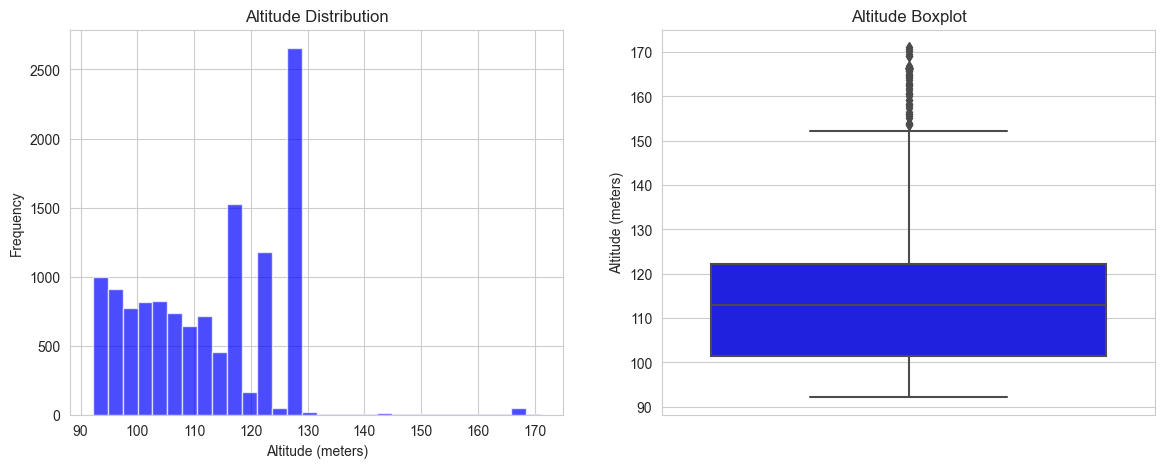

In [12]:

sns.set_style("whitegrid")

# Create subplots for data distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram for altitude
df['Altitude'].plot(kind='hist', bins=30, ax=axes[0], color='blue', alpha=0.7)
axes[0].set_title("Altitude Distribution")
axes[0].set_xlabel("Altitude (meters)")
axes[0].set_ylabel("Frequency")

# Boxplot for altitude
sns.boxplot(y=df['Altitude'], ax=axes[1], color='blue')
axes[1].set_title("Altitude Boxplot")
axes[1].set_ylabel("Altitude (meters)")

plt.show()




**Histogram** (Altitude Distribution)

Bimodal distribution with specific peaks:**  
  - Two pronounced peaks are observed around **120 m and 130 m**.  
  - This suggests that most images were captured at these specific altitudes.  
  - It could be due to a **planned drone flight strategy**.  

Low altitude variability:**  
  - Most of the data is concentrated between **90 m and 130 m**.  
  - There are few images outside this range, indicating **little variation in height** during capture.  

---

**Boxplot** (Altitude Boxplot)

Outliers above ~135 m:**  
  - The points above the top whisker of the boxplot indicate **outliers**.  
  - These could be images taken under different conditions or **errors in capture**.  

Median around 110-115 m:**  
  - Half of the images have an altitude between **~100 m and ~125 m**.  
  - The line inside the box represents the **median**, which is close to **110 m**.  

Well-defined interquartile range (IQR):**  
  - The box covers approximately the **range between 95 m and 125 m**.  
  - This means that **50% of the images fall within this interval**.  


### 02.6 Geospatial Heatmap 

In [13]:
# Install necessary libraries
import folium
from folium.plugins import HeatMap

# Create a map centered at the median latitude and longitude
m = folium.Map(location=[df['Latitude'].median(), df['Longitude'].median()], zoom_start=14)

# Add heatmap layer
heat_data = list(zip(df['Latitude'], df['Longitude']))
HeatMap(heat_data).add_to(m)

# Display the map
m

## 03. FEATURE ENGINEERING

pip install geopy

### 03.1

- Extract camera-related metadata (focal length, exposure time, timestamp).
- Estimate image overlap using GPS data.
- Prepare the dataset for further feature selection.

##### 03.1.1 Extract more metadata: focal length, exposure time, timestamp (make sense??)

##### 03.1.2 Estimate image using GPS data

- Objective:

    - Calculate the distance between images using GPS coordinates.
    - Determine the overlap to identify redundant images.

- Method:

    - Use the Haversine formula to calculate the distance between images based on latitude and longitude.
    - Identify images with minimal distance to determine redundancy.


In [14]:
from geopy.distance import geodesic

# Load dataset
csv_path = r"C:\Users\Edu\Documents\GitHub\DeepPrune\data\photogrammetry_dataset_01.csv"
df = pd.read_csv(csv_path)

# Function to calculate Haversine distance
def calculate_distance(coord1, coord2):
    return geodesic(coord1, coord2).meters

# Sort dataset by filename (ensuring sequential order)
df = df.sort_values(by="Image Name").reset_index(drop=True)

# Initialize distance list
distances = [0]  # First image has no previous reference

# Compute distances between consecutive images
for i in range(1, len(df)):
    coord_prev = (df.loc[i-1, "Latitude"], df.loc[i-1, "Longitude"])
    coord_curr = (df.loc[i, "Latitude"], df.loc[i, "Longitude"])
    dist = calculate_distance(coord_prev, coord_curr)
    distances.append(dist)

# Add distances to DataFrame
df["Distance to Previous (m)"] = distances

# Define overlap threshold (e.g., images closer than 5m are considered redundant)
overlap_threshold = 5  # Adjust based on 3D reconstruction needs
df["Redundant"] = df["Distance to Previous (m)"] < overlap_threshold

# Save new dataset
output_path = r"C:\Users\Edu\Documents\GitHub\DeepPrune\data\photogrammetry_dataset_extended.csv"
df.to_csv(output_path, index=False)

# Display summary
print("Dataset updated with distance calculations!")
print(df.head())


Dataset updated with distance calculations!
                      Image Name   
0  DJI_20231018083700_0001_V.JPG  \
1  DJI_20231018083701_0002_V.JPG   
2  DJI_20231018083702_0003_V.JPG   
3  DJI_20231018083702_0004_V.JPG   
4  DJI_20231018083703_0005_V.JPG   

                                           File Path   Latitude  Longitude   
0  E:\ML Train\00_Josef-Orlopp\05_i-linkes-dach-s...  52.522767  13.487282  \
1  E:\ML Train\00_Josef-Orlopp\05_i-linkes-dach-s...  52.522767  13.487282   
2  E:\ML Train\00_Josef-Orlopp\05_i-linkes-dach-s...  52.522767  13.487282   
3  E:\ML Train\00_Josef-Orlopp\05_i-linkes-dach-s...  52.522767  13.487282   
4  E:\ML Train\00_Josef-Orlopp\05_i-linkes-dach-s...  52.522767  13.487282   

   Altitude  Orientation  Distance to Previous (m)  Redundant  
0    93.753            1                  0.000000       True  
1    93.771            1                  0.003621       True  
2    93.860            1                  0.008379       True  
3    93.973   

In [15]:
df.head()

,Image Name,File Path,Latitude,Longitude,Altitude,Orientation,Distance to Previous (m),Redundant
0,DJI_20231018083700_0001_V.JPG,E:\ML Train\00_Josef-Orlopp\05_i-linkes-dach-s...,52.522767,13.487282,93.753,1,0.000000,True
1,DJI_20231018083701_0002_V.JPG,E:\ML Train\00_Josef-Orlopp\05_i-linkes-dach-s...,52.522767,13.487282,93.771,1,0.003621,True
2,DJI_20231018083702_0003_V.JPG,E:\ML Train\00_Josef-Orlopp\05_i-linkes-dach-s...,52.522767,13.487282,93.860,1,0.008379,True
3,DJI_20231018083702_0004_V.JPG,E:\ML Train\00_Josef-Orlopp\05_i-linkes-dach-s...,52.522767,13.487282,93.973,1,0.013555,True
4,DJI_20231018083703_0005_V.JPG,E:\ML Train\00_Josef-Orlopp\05_i-linkes-dach-s...,52.522767,13.487282,94.159,1,0.007542,True


In [16]:
print(df.describe())


           Latitude     Longitude      Altitude  Orientation   
count  12609.000000  12609.000000  12609.000000      12609.0  \
mean      52.522311     13.488658    112.519313          1.0   
std        0.000279      0.000876     12.521432          0.0   
min       52.521795     13.487037     92.145000          1.0   
25%       52.522064     13.487993    101.425000          1.0   
50%       52.522277     13.488696    113.032000          1.0   
75%       52.522526     13.489323    122.287000          1.0   
max       52.522959     13.490600    171.095000          1.0   

       Distance to Previous (m)  
count              12609.000000  
mean                   1.583833  
std                    2.897464  
min                    0.000000  
25%                    0.032643  
50%                    0.482731  
75%                    2.894915  
max                  130.123649  
